In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

!pip install catboost -q
from catboost import CatBoostClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')
heart_data_orig = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')
heart_data_prepro = heart_data_orig.copy()

################################################ Inspection of The Dataset ############################################
heart_data_prepro.info()
#No missing values in the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [3]:
heart_data_prepro.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
counts = heart_data_prepro['DEATH_EVENT'].value_counts()
print(f"Number of 0s (survived): {counts[0]}")
print(f"Number of 1s (death events): {counts[1]}")

Number of 0s (survived): 203
Number of 1s (death events): 96


**Correlation Matrix**

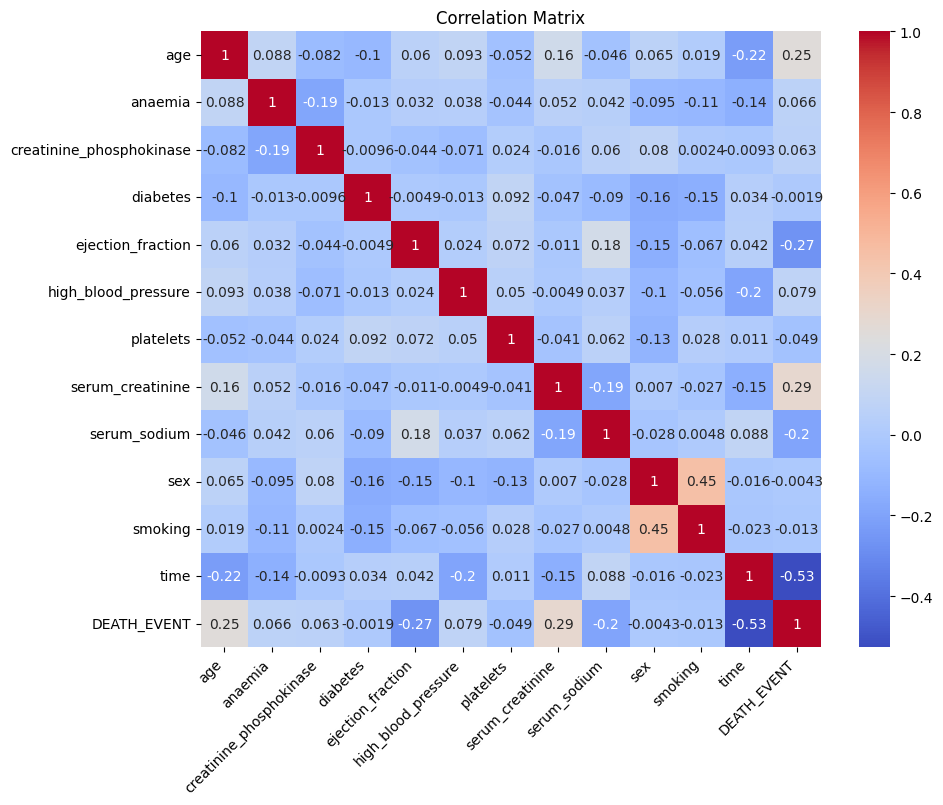

In [5]:
import seaborn as sns
corr_mat = heart_data_prepro.corr()

plt.figure(figsize=(10,8))
ax = sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

**Preprocessing**

In [6]:
X = heart_data_prepro.drop('DEATH_EVENT', axis=1)
y = heart_data_prepro["DEATH_EVENT"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

continous_feat = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
scaler = StandardScaler()
X_train[continous_feat] = scaler.fit_transform(X_train[continous_feat])
X_test[continous_feat] = scaler.transform(X_test[continous_feat])

acc_results_log = []
f1_results_log = []
rec_results_log = []

**Functions**

In [7]:
def train_models_setup(X_train, y_train, X_test, y_test, model_type, param_dist, acc_results_log, rec_results_log, f1_results_log):

  cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
  rs_search = RandomizedSearchCV(estimator=model_type, param_distributions=param_dist, n_iter=25, cv=cv, scoring='f1', return_train_score=True, verbose=1, random_state=0, refit=False)
  rs_search.fit(X_train, y_train)

  print("\n")
  best_params = rs_search.best_params_
  best_params_disp = {}
  for k, v in best_params.items():
    if isinstance(v, float):
        best_params_disp[k] = round(float(v), 4)
    else:
        best_params_disp[k] = v

  print(f"Best parameters: {best_params_disp}")

  best_model = model_type.set_params(**best_params)
  best_model.fit(X_train, y_train)

  y_pred = best_model.predict(X_test)

  cv_acc_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')
  cv_rec_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='recall')
  cv_f1_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='f1')

  cv_acc = np.mean(cv_acc_scores)
  cv_rec = np.mean(cv_rec_scores)
  cv_f1 = np.mean(cv_f1_scores)
  cv_acc_std = np.std(cv_acc_scores)
  cv_rec_std = np.std(cv_rec_scores)
  cv_f1_std = np.std(cv_f1_scores)

  acc_results_log.append(cv_acc)
  rec_results_log.append(cv_rec)
  f1_results_log.append(cv_f1)

  test_acc = accuracy_score(y_test, y_pred)
  test_rec = recall_score(y_test, y_pred)
  test_f1 = f1_score(y_test, y_pred)

  acc_results_log.append(test_acc)
  rec_results_log.append(test_rec)
  f1_results_log.append(test_f1)

  print("\n")

  results = pd.DataFrame(rs_search.cv_results_)
  print("\nRandom Search CV Results:")
  print(results[['mean_train_score', 'mean_test_score']])

  print("\n")

  cv_train_mean = results['mean_train_score'].mean()
  cv_train_std = results['mean_train_score'].std()

  print("\n")
  print(f"CV validation Accuracy: {cv_acc:.4f} ± {cv_acc_std:.4f}")
  print("\n")
  print(f"CV validation F1-score: {cv_f1:.4f} ± {cv_f1_std:.4f}")
  print(f"CV train F1-score: {cv_train_mean:.4f} ± {cv_train_std:.4f}")

  print("\nFinal classification report:")
  print(classification_report(y_test, y_pred))

  return best_model, best_params


**Without Balancing**

**Random Forest**

In [8]:
rf_model = RandomForestClassifier(random_state=0)
param_dist = {
    'n_estimators': randint(180, 301),
    'max_depth': randint(3, 7),
    'min_samples_split': randint(2, 9),
    'min_samples_leaf': randint(5, 21),
}

best_rf_imb,_= train_models_setup(X_train, y_train, X_test, y_test, rf_model, param_dist, acc_results_log, rec_results_log, f1_results_log)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


Best parameters: {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 279}



Random Search CV Results:
    mean_train_score  mean_test_score
0           0.746035         0.714632
1           0.768998         0.717013
2           0.820247         0.734799
3           0.771872         0.699197
4           0.752983         0.710236
5           0.793541         0.729643
6           0.805801         0.716310
7           0.763194         0.721775
8           0.794698         0.698831
9           0.858847         0.769077
10          0.805412         0.688225
11          0.825516         0.755616
12          0.807301         0.679870
13          0.862988         0.765744
14          0.827649         0.755616
15          0.788734         0.719286
16          0.810201         0.695621
17          0.801487         0.732731
18          0.748981         0.714632
19          0.782259         0.709870
20    

**XGB Model**

In [9]:
xgb_model = XGBClassifier(
    random_state=0,
    use_label_encoder=False,
    eval_metric='logloss')

param_dist = {
    'n_estimators': randint(200, 301),
    'max_depth': randint(5, 11),
    'learning_rate': uniform(0.01, 0.25),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'min_child_weight': randint(4, 12),
    'gamma': uniform(3, 6)
}

best_xgb_imb,_ = train_models_setup(X_train, y_train, X_test, y_test, xgb_model, param_dist, acc_results_log, rec_results_log, f1_results_log)


Fitting 10 folds for each of 25 candidates, totalling 250 fits


Best parameters: {'colsample_bytree': 0.7404, 'gamma': 7.132, 'learning_rate': 0.2301, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 282, 'subsample': 0.7826}



Random Search CV Results:
    mean_train_score  mean_test_score
0           0.718402         0.708616
1           0.784868         0.726716
2           0.785526         0.716893
3           0.747109         0.699771
4           0.753231         0.714771
5           0.807836         0.724595
6           0.762938         0.714771
7           0.742503         0.694317
8           0.710616         0.661981
9           0.728509         0.699771
10          0.633956         0.573167
11          0.616256         0.541785
12          0.764080         0.715604
13          0.728878         0.712498
14          0.769947         0.752133
15          0.785529         0.740818
16          0.681415         0.635165
17          0.729872         0.699771
18          0.77

**CatBoost**

In [10]:
cat_model = CatBoostClassifier(verbose=0, random_state=0)

param_dist = {
    'depth': randint(2, 4),
    'learning_rate': uniform(0.08, 0.1),
    'l2_leaf_reg': uniform(18, 23),
    'iterations': randint(100, 181),
}

best_cat_imb,_ = train_models_setup(X_train, y_train, X_test, y_test, cat_model, param_dist, acc_results_log, rec_results_log, f1_results_log)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


Best parameters: {'depth': 2, 'iterations': 115, 'l2_leaf_reg': 28.918, 'learning_rate': 0.1424}



Random Search CV Results:
    mean_train_score  mean_test_score
0           0.803876         0.751617
1           0.792394         0.725082
2           0.839952         0.749769
3           0.822044         0.739086
4           0.807921         0.738727
5           0.836364         0.732892
6           0.830866         0.743498
7           0.785305         0.714826
8           0.825568         0.761249
9           0.821772         0.746276
10          0.815673         0.747894
11          0.808480         0.765824
12          0.815951         0.746276
13          0.760610         0.710247
14          0.795600         0.733416
15          0.799553         0.747894
16          0.831034         0.743498
17          0.792136         0.725733
18          0.806073         0.768284
19          0.790502         0.714826
20         

**With SMOTE**

**Random Forest**

In [11]:
rf = RandomForestClassifier(random_state=0)
smote = SMOTE(random_state=0)

smote_pipe = Pipeline([
    ('smote', smote),
    ('rf', rf)
])

param_dist = {
    'rf__n_estimators': randint(150, 301),
    'rf__max_depth': randint(3, 6),
    'rf__min_samples_split': randint(2, 9),
    'rf__min_samples_leaf': randint(10, 25),
    'smote__sampling_strategy': uniform(0.5, 0.35)
}

best_rf_smote,_= train_models_setup(X_train, y_train, X_test, y_test,smote_pipe, param_dist, acc_results_log, rec_results_log, f1_results_log)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


Best parameters: {'rf__max_depth': 4, 'rf__min_samples_leaf': 14, 'rf__min_samples_split': 5, 'rf__n_estimators': 229, 'smote__sampling_strategy': 0.8045}



Random Search CV Results:
    mean_train_score  mean_test_score
0           0.818341         0.773748
1           0.819430         0.746323
2           0.799866         0.736296
3           0.793022         0.717976
4           0.825439         0.778933
5           0.837878         0.749105
6           0.810867         0.753005
7           0.798207         0.737663
8           0.824989         0.729785
9           0.819448         0.759317
10          0.810569         0.768695
11          0.807069         0.767450
12          0.822254         0.739812
13          0.806744         0.720785
14          0.835128         0.760289
15          0.801642         0.743271
16          0.818310         0.759317
17          0.832930         0.754767
18          0.803310         

**XGB Model**

In [12]:
xgb = XGBClassifier(
    random_state=0,
    use_label_encoder=False,
    eval_metric='logloss')

smote = SMOTE(random_state=0)
smote_pipe = Pipeline([
    ('smote', smote),
    ('xgb', xgb)
])

param_dist = {
    'xgb__n_estimators': randint(200, 351),
    'xgb__max_depth': randint(5, 12),
    'xgb__learning_rate': uniform(0.01, 0.15),
    'xgb__subsample': uniform(0.5, 0.5),
    'xgb__colsample_bytree': uniform(0.6, 0.4),
    'xgb__min_child_weight': randint(4, 12),
    'xgb__gamma': uniform(3, 6),
    'smote__sampling_strategy': uniform(0.5, 0.2)
}

best_xgb_smote,_ = train_models_setup(X_train, y_train, X_test, y_test,smote_pipe, param_dist, acc_results_log, rec_results_log, f1_results_log)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


Best parameters: {'smote__sampling_strategy': 0.6319, 'xgb__colsample_bytree': 0.8133, 'xgb__gamma': 4.3832, 'xgb__learning_rate': 0.0692, 'xgb__max_depth': 9, 'xgb__min_child_weight': 7, 'xgb__n_estimators': 321, 'xgb__subsample': 0.7351}



Random Search CV Results:
    mean_train_score  mean_test_score
0           0.789390         0.750766
1           0.807665         0.744838
2           0.746041         0.673239
3           0.809945         0.728930
4           0.805845         0.724286
5           0.803536         0.754691
6           0.795251         0.726395
7           0.798365         0.733379
8           0.797448         0.759852
9           0.785596         0.748172
10          0.784578         0.707885
11          0.802273         0.725580
12          0.797921         0.751625
13          0.817783         0.726810
14          0.773557         0.708595
15          0.751409         0.709165
16          0.783089

**CatBoost**

In [13]:
cat = CatBoostClassifier(
    verbose=0,
    loss_function='Logloss',
    random_state=0
)

smote = SMOTE(random_state=0)
smote_pipe = Pipeline([
    ('smote', smote),
    ('cat', cat)
])

param_dist = {
    'cat__depth': randint(2, 4),
    'cat__learning_rate': uniform(0.04, 0.02),
    'cat__l2_leaf_reg': uniform(40, 50),
    'cat__iterations': randint(300, 551),
    'smote__sampling_strategy': uniform(0.5, 0.2)
}

best_cat_smote,_ = train_models_setup(X_train, y_train, X_test, y_test,smote_pipe, param_dist, acc_results_log, rec_results_log, f1_results_log)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


Best parameters: {'cat__depth': 3, 'cat__iterations': 502, 'cat__l2_leaf_reg': 60.7331, 'cat__learning_rate': 0.0453, 'smote__sampling_strategy': 0.6548}



Random Search CV Results:
    mean_train_score  mean_test_score
0           0.864249         0.736655
1           0.921456         0.741466
2           0.883537         0.734484
3           0.831631         0.742895
4           0.928658         0.740827
5           0.870466         0.733795
6           0.876392         0.722943
7           0.924698         0.751963
8           0.885159         0.728752
9           0.896603         0.737889
10          0.857266         0.750388
11          0.892828         0.737292
12          0.871204         0.744482
13          0.846142         0.741051
14          0.880955         0.746279
15          0.943598         0.742654
16          0.923441         0.726396
17          0.876003         0.734786
18          0.910400         0

**With Class weights**

**Random Forest**

In [14]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

rf_model = RandomForestClassifier(random_state=0)
param_dist = {
    'n_estimators': randint(150, 351),
    'max_depth': randint(5, 15),
    'min_samples_split': randint(5, 20),
    'min_samples_leaf': randint(10, 40),
    'class_weight': [{0: w0, 1: w1} for w0 in np.linspace(1, 1.25, 9) for w1 in np.linspace(1, 2.5, 9)]
}

best_rf_weight,_ = train_models_setup(X_train, y_train, X_test, y_test,rf_model, param_dist, acc_results_log, rec_results_log, f1_results_log)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


Best parameters: {'class_weight': {0: np.float64(1.21875), 1: np.float64(2.125)}, 'max_depth': 5, 'min_samples_leaf': 27, 'min_samples_split': 7, 'n_estimators': 186}



Random Search CV Results:
    mean_train_score  mean_test_score
0           0.854284         0.735023
1           0.615970         0.573582
2           0.801957         0.768426
3           0.790477         0.725346
4           0.746165         0.710386
5           0.776747         0.721537
6           0.803347         0.755926
7           0.743044         0.686976
8           0.808751         0.746861
9           0.802995         0.726937
10          0.813647         0.751220
11          0.832649         0.728593
12          0.814496         0.751028
13          0.829729         0.750195
14          0.804384         0.747184
15          0.519590         0.401717
16          0.822464         0.745914
17          0.808749         0.742409
18          0.764

**XGB Model**

In [15]:
xgb_model = XGBClassifier(
    random_state=0,
    use_label_encoder=False,
    eval_metric='logloss')

param_dist = {
    'n_estimators': randint(200, 351),
    'max_depth': randint(5, 15),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(4, 12),
    'gamma': uniform(3, 11),
    'scale_pos_weight': uniform(0.7, 0.3)

}
best_xgb_weight,_ = train_models_setup(X_train, y_train, X_test, y_test,xgb_model, param_dist, acc_results_log, rec_results_log, f1_results_log)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


Best parameters: {'colsample_bytree': 0.9717, 'gamma': 6.5043, 'learning_rate': 0.1435, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 232, 'scale_pos_weight': 0.9524, 'subsample': 0.6324}



Random Search CV Results:
    mean_train_score  mean_test_score
0           0.639761         0.623776
1           0.696894         0.663810
2           0.798851         0.737705
3           0.749130         0.706438
4           0.000000         0.000000
5           0.722430         0.716548
6           0.703850         0.640049
7           0.467362         0.448275
8           0.745089         0.694317
9           0.713742         0.691665
10          0.501810         0.449213
11          0.788607         0.737705
12          0.677057         0.646500
13          0.788018         0.771605
14          0.694608         0.659540
15          0.787474         0.753860
16          0.718875         0.699771
17          0.719813     

**CatBoost**

In [16]:
cat_model = CatBoostClassifier(
    verbose=0,
    loss_function='Logloss',
    random_state=0
)

param_dist = {
    'depth': randint(2, 5),
    'learning_rate': uniform(0.03, 0.05),
    'l2_leaf_reg': uniform(50, 100),
    'iterations': randint(50, 200),
    'class_weights': [{0: w0, 1: w1} for w0 in np.linspace(1, 1.25, 9) for w1 in np.linspace(1, 2.5, 9)]
}

best_cat_weight,_ = train_models_setup(X_train, y_train, X_test, y_test,cat_model, param_dist, acc_results_log, rec_results_log, f1_results_log)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


Best parameters: {'class_weights': {0: np.float64(1.03125), 1: np.float64(2.5)}, 'depth': 2, 'iterations': 155, 'l2_leaf_reg': 94.995, 'learning_rate': 0.0607}



Random Search CV Results:
    mean_train_score  mean_test_score
0           0.799601         0.718885
1           0.728392         0.720117
2           0.739007         0.720117
3           0.719887         0.703581
4           0.798107         0.710094
5           0.791588         0.714728
6           0.718835         0.703581
7           0.800029         0.727013
8           0.716944         0.711786
9           0.803785         0.759451
10          0.718835         0.703581
11          0.721617         0.707390
12          0.775486         0.700027
13          0.719325         0.703581
14          0.729940         0.724513
15          0.728374         0.716308
16          0.744128         0.720117
17          0.794456         0.718062
18          0.780588    

**Plot Scores**

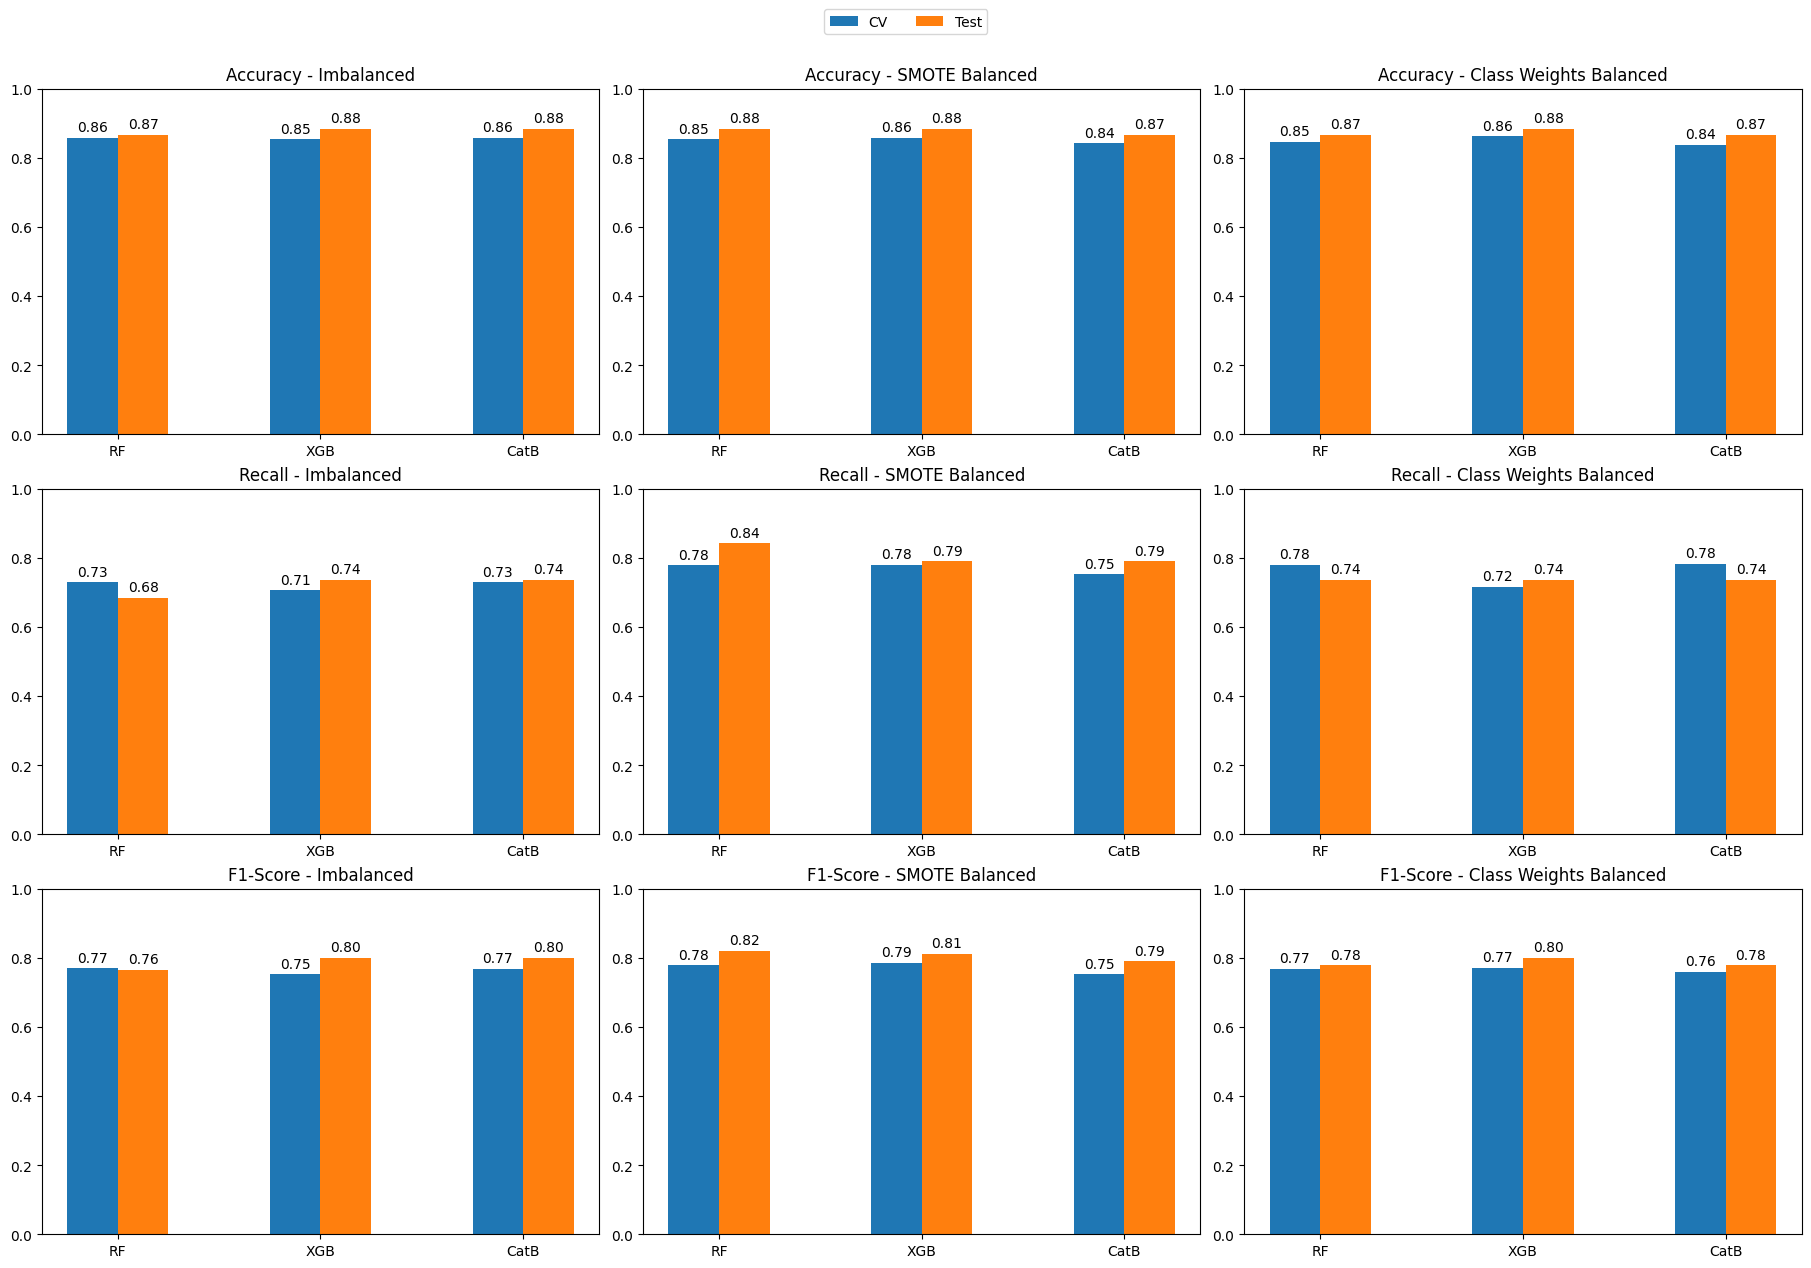

In [17]:
model_labels = ['RF', 'XGB', 'CatB']
x = np.arange(len(model_labels))
width = 0.25

situation_names = ['Imbalanced', 'SMOTE Balanced', 'Class Weights Balanced']
metric_logs = [acc_results_log, rec_results_log, f1_results_log]
metric_names = ['Accuracy', 'Recall', 'F1-Score']

def disp_situation_metric_values(metric_log, situation_idx):
    start = situation_idx * 6
    cv = [metric_log[start + i] for i in range(0, 6, 2)]
    test = [metric_log[start + i] for i in range(1, 6, 2)]
    return cv, test

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12), constrained_layout=True)

for row, (metric_log, metric_name) in enumerate(zip(metric_logs, metric_names)):
    for col, situation in enumerate(situation_names):
        ax = axes[row, col]

        cv_values, test_values = disp_situation_metric_values(metric_log, col)

        bars_cv = ax.bar(x - width/2, cv_values, width, label='CV')
        bars_test = ax.bar(x + width/2, test_values, width, label='Test')

        ax.set_title(f'{metric_name} - {situation}')
        ax.set_xticks(x)
        ax.set_xticklabels(model_labels)
        ax.set_ylim(0, 1)

        for bar in bars_cv + bars_test:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,
                f'{height:.2f}',
                ha='center',
                va='bottom'
            )
fig.legend(['CV', 'Test'], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.05))
plt.show()
